In [13]:
import sys
sys.path.append('../')

from utilidades import *
import warnings
warnings.filterwarnings('ignore')

# Data

In [14]:
# Fazendo o load das embeddings do TJRN
emb_TJRN_BERT = np.load('Embeddings/TJRN_MBERT.npy')
emb_TJRN_TFIDF = np.load('Embeddings/TJRN_TFIDF.npy')

# Criando as labels para TJRN
# OBS: os 30000 textos estão bem divididos, isso significa que os primeiros 3000 textos pertencem a primeira classe,
# os 3000 textos seguintes pertencem a segunda classe e assim por diante.
aux_list = ['196', '198', '200', '219', '220', '339', '458', '461', '463', '785']
TJRN_labels = [[classe]*3000 for classe in aux_list]
TJRN_labels = np.concatenate(TJRN_labels, axis=None)

# Fazendo o load das embeddings do 20Newsgroups
obj_NG_BERT = np.load('Embeddings/NG_BERT.npy', allow_pickle=True) # Permite fazer o load de objetos (sparce matrix, nesse caso)
obj_NG_TFIDF = np.load('Embeddings/NG_TFIDF.npy', allow_pickle=True)

# Separando as embeddings e as labels
emb_NG_BERT = obj_NG_BERT.item().get('data')
emb_NG_TFIDF = np.array(obj_NG_TFIDF.item().get('data'))
NG_labels = obj_NG_BERT.item().get('target')

print(f"Shape TJRN_BERT: {emb_TJRN_BERT.shape}\nShape TJRN_TFIDF: {emb_TJRN_TFIDF.shape}\nShape TJRN_labels: {TJRN_labels.shape}\n")
print(f"Shape NG_BERT: {emb_NG_BERT.shape}\nShape NG_TFIDF: {emb_NG_TFIDF.shape}\nShape NG_labels: {NG_labels.shape}")

Shape TJRN_BERT: (30000, 768)
Shape TJRN_TFIDF: (30000, 1446)
Shape TJRN_labels: (30000,)

Shape NG_BERT: (18846, 768)
Shape NG_TFIDF: (18846, 1352)
Shape NG_labels: (18846,)


<h2><b>PEGANDO PARTE DOS DADOS</b></h2>

Para evitar trabalhar com todos os textos vamos pegar apenas alguns:
<li>300 textos de cada classe do TJRN</li>
<li>Os textos das classes 'comp.windows.x', 'rec.sport.baseball' e 'talk.politics.misc'</li>

<h3>TJRN</h3>

In [15]:
# Vamos utilizar o train_test_split para fazer uma divisão correta dos dados do TJRN
from sklearn.model_selection import train_test_split

emb_TJRN_BERT, _, _, _ = train_test_split(emb_TJRN_BERT, TJRN_labels, train_size=0.1, random_state=42, stratify=TJRN_labels)
emb_TJRN_TFIDF, _, TJRN_labels, _ = train_test_split(emb_TJRN_TFIDF, TJRN_labels, train_size=0.1, random_state=42, stratify=TJRN_labels)

<h3>20Newsgroups</h3>

comp.windows.x -> classe 5

rec.sport.baseball -> classe 9

talk.politics.misc -> classe 18

In [16]:
# Encontrando os índices das classes selecionadas
index = np.where(np.isin(NG_labels, [5, 9, 18]))

# Selecionando apenas os textos das classes selecionadas
emb_NG_BERT = emb_NG_BERT[index]
emb_NG_TFIDF = emb_NG_TFIDF[index]
NG_labels = NG_labels[index]

# Vamos utilizar o train_test_split para fazer uma divisão correta dos dados do NG
emb_NG_BERT, _, _, _ = train_test_split(emb_NG_BERT, NG_labels, train_size=0.33, random_state=42, stratify=NG_labels)
emb_NG_TFIDF, _, NG_labels, _ = train_test_split(emb_NG_TFIDF, NG_labels, train_size=0.33, random_state=42, stratify=NG_labels)

In [17]:
print(f"Shape TJRN_BERT: {emb_TJRN_BERT.shape}\nShape TJRN_TFIDF: {emb_TJRN_TFIDF.shape}\nShape TJRN_labels: {TJRN_labels.shape}\n")
print(f"Shape NG_BERT: {emb_NG_BERT.shape}\nShape NG_TFIDF: {emb_NG_TFIDF.shape}\nShape NG_labels: {NG_labels.shape}")

Shape TJRN_BERT: (3000, 768)
Shape TJRN_TFIDF: (3000, 1446)
Shape TJRN_labels: (3000,)

Shape NG_BERT: (909, 768)
Shape NG_TFIDF: (909, 1352)
Shape NG_labels: (909,)


In [18]:
NG_target_names = np.unique(NG_labels)
TJRN_target_names = np.unique(TJRN_labels)

# Deep Clustering

<h3>Redução de dimensionalidade</h3>

In [19]:
from sklearn.manifold import TSNE

X_emb_TJRN_TFIDF = TSNE().fit_transform(emb_TJRN_TFIDF)
X_emb_TJRN_BERT = TSNE().fit_transform(emb_TJRN_BERT)

X_emb_NG_TFIDF = TSNE().fit_transform(emb_NG_TFIDF)
X_emb_NG_BERT = TSNE().fit_transform(emb_NG_BERT)

# Clusterização

In [20]:
# Importando os pacotes necessários
import tensorflow as tf
from tensorflow import keras
from scipy.stats import zscore
from sklearn.cluster import KMeans

In [21]:
def return_autoencoder(input_dim, encoding_dim):
    # Input Layer
    encoder_input = keras.layers.Input(shape=(input_dim,))
    # Encoder Layer
    encoder_output = keras.layers.Dense(encoding_dim, activation='tanh')(encoder_input)
    # Encoder Model
    encoder = keras.Model(encoder_input, encoder_output, name='encoder')
    # Output Layer
    decoder_output = keras.layers.Dense(input_dim, activation='tanh')(encoder_output)
    # Autoencoder Model
    autoencoder = keras.models.Model(inputs=encoder_input, outputs=decoder_output)
    # Definindo otimizador e compilando o modelo
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    autoencoder.compile(opt, loss = 'mse')
    return autoencoder, encoder

In [22]:
# Definindo o autoencoder 
TJRN_BERT_input_dim = emb_TJRN_BERT.shape[1]
TJRN_TFIDF_input_dim = emb_TJRN_TFIDF.shape[1]

NG_BERT_input_dim = emb_NG_BERT.shape[1]
NG_TFIDF_input_dim = emb_NG_TFIDF.shape[1]

autoencoder_TJRN_BERT, encoder_TJRN_BERT = return_autoencoder(TJRN_BERT_input_dim, encoding_dim = 50)
autoencoder_TJRN_TFIDF, encoder_TJRN_TFIDF = return_autoencoder(TJRN_TFIDF_input_dim, encoding_dim = 50)

autoencoder_NG_BERT, encoder_NG_BERT = return_autoencoder(NG_BERT_input_dim, encoding_dim = 50)
autoencoder_NG_TFIDF, encoder_NG_TFIDF = return_autoencoder(NG_TFIDF_input_dim, encoding_dim = 50)

# Treinando o autoencoder

In [23]:
# TJRN BERT
autoencoder_TJRN_BERT.fit(emb_TJRN_BERT, emb_TJRN_BERT, epochs=50, shuffle=True, validation_split = 0.1)

# TJRN TFIDF
autoencoder_TJRN_TFIDF.fit(emb_TJRN_TFIDF, emb_TJRN_TFIDF, epochs=50, shuffle=True, validation_split = 0.1)

# NG BERT
autoencoder_NG_BERT.fit(emb_NG_BERT, emb_NG_BERT, epochs=50, shuffle=True, validation_split = 0.1)

# NG TFIDF
autoencoder_NG_TFIDF.fit(emb_NG_TFIDF, emb_NG_TFIDF, epochs=50, shuffle=True, validation_split = 0.1)

Epoch 1/50
85/85 [==============================] - 1s 4ms/step - loss: 0.0369 - val_loss: 0.0208
Epoch 2/50
85/85 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0167
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 4/50
85/85 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 5/50
85/85 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 6/50
85/85 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 7/50
85/85 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 8/50
85/85 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 9/50
85/85 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 10/50
85/85 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 11/50
85/85 [

# Recuperando o espaço latente e rodando o KMeans

In [24]:
el_TJRN_BERT = encoder_TJRN_BERT.predict(emb_TJRN_BERT)
el_TJRN_TFIDF = encoder_TJRN_TFIDF.predict(emb_TJRN_TFIDF)

el_NG_BERT = encoder_NG_BERT.predict(emb_NG_BERT)
el_NG_TFIDF = encoder_NG_TFIDF.predict(emb_NG_TFIDF)

print(f'Shape espaço latente TJRN BERT: {el_TJRN_BERT.shape}')
print(f'Shape espaço latente TJRN TFIDF: {el_TJRN_TFIDF.shape}')
print(f'Shape espaço latente NG BERT: {el_NG_BERT.shape}')
print(f'Shape espaço latente NG TFIDF: {el_NG_TFIDF.shape}')

29/29 [==============================] - 0s 1ms/step
Shape espaço latente TJRN BERT: (3000, 50)
Shape espaço latente TJRN TFIDF: (3000, 50)
Shape espaço latente NG BERT: (909, 50)
Shape espaço latente NG TFIDF: (909, 50)


In [25]:
km_labels_TJRN_BERT = KMeans(n_clusters = 10).fit_predict(el_TJRN_BERT)
km_labels_TJRN_TFIDF = KMeans(n_clusters = 10).fit_predict(el_TJRN_TFIDF)
km_labels_NG_BERT = KMeans(n_clusters = 3).fit_predict(el_NG_BERT)
km_labels_NG_TFIDF = KMeans(n_clusters = 3).fit_predict(el_NG_TFIDF)

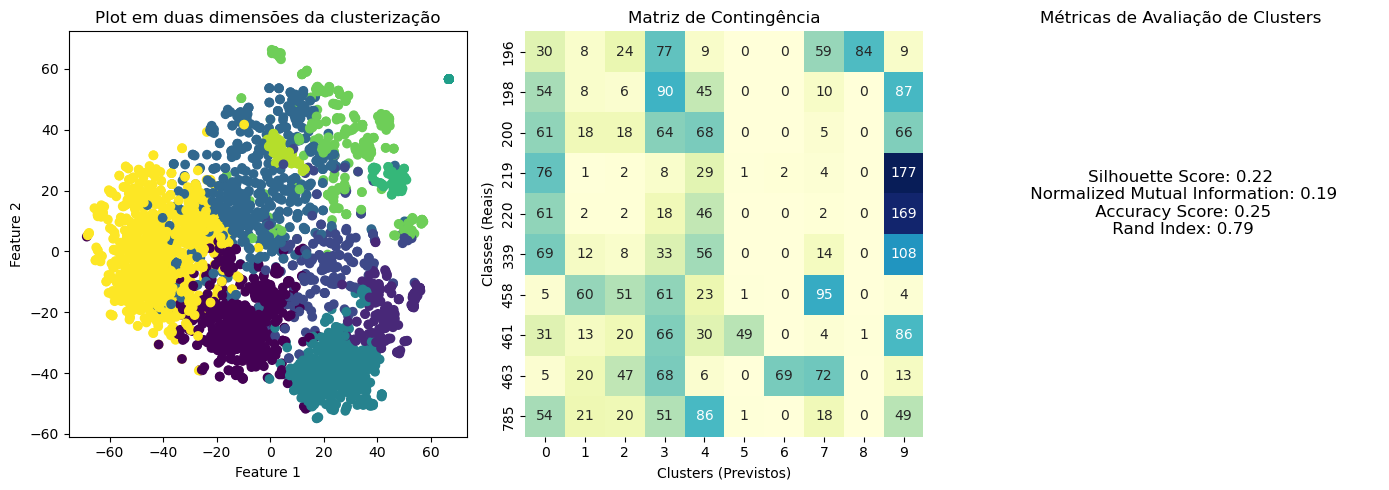

In [26]:
# TJRN BERT

plot_cluster_evaluation(X_emb_TJRN_BERT, TJRN_labels, km_labels_TJRN_BERT, TJRN_target_names)

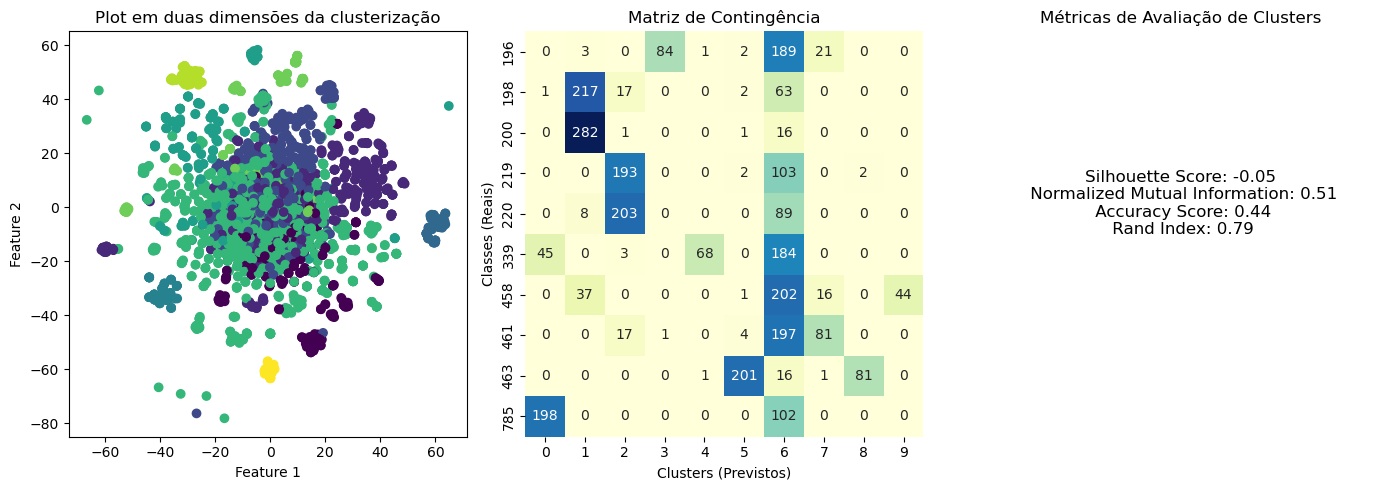

In [27]:
# TJRN TFIDF

plot_cluster_evaluation(X_emb_TJRN_TFIDF, TJRN_labels, km_labels_TJRN_TFIDF, TJRN_target_names)

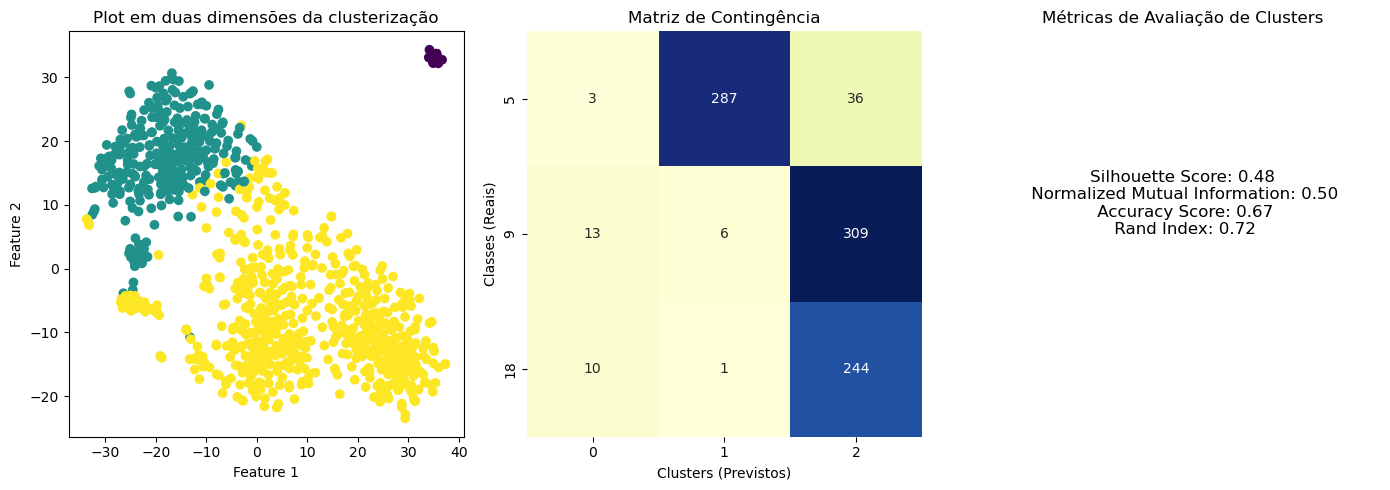

In [28]:
# NG BERT

plot_cluster_evaluation(X_emb_NG_BERT, NG_labels, km_labels_NG_BERT, NG_target_names)

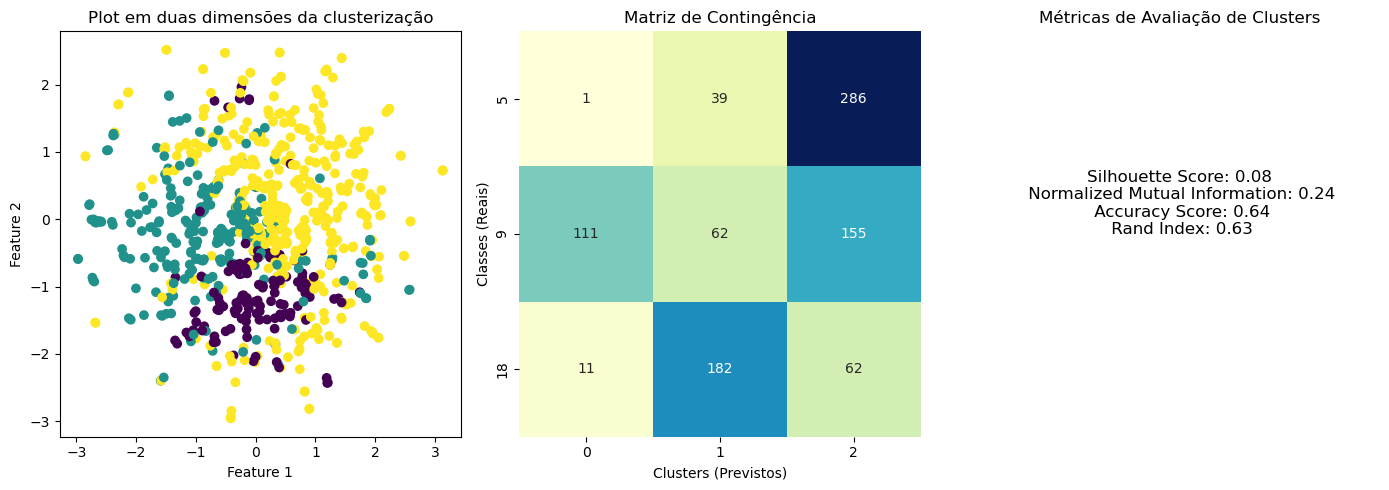

In [29]:
# NG TFIDF

plot_cluster_evaluation(X_emb_NG_TFIDF, NG_labels, km_labels_NG_TFIDF, NG_target_names)